In [ ]:
# Install this module to access AlphaVantage financial API
!pip install alpha_vantage

In [1]:
%matplotlib notebook

In [2]:
# Dependencies
from alpha_vantage.timeseries import TimeSeries
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import pandas as pd
import requests
import pathlib
import time
from datetime import datetime
from config import api_key

# Create an AlphaVantage API object
ts = TimeSeries(api_key, output_format='pandas')

In [3]:
# Read the csv file that contains the P/E ratio for our chosen companies
filepath = pathlib.Path("pe_data.csv")
pe_df_raw= pd.read_csv(filepath)

pe_df_raw

,Industry,Ticker,Company,Date,PE Ratio
0,Entertainment,NFLX,Netflix,6/28/2019,144.05
1,Entertainment,NFLX,Netflix,9/30/2019,85.50
2,Entertainment,NFLX,Netflix,12/31/2019,78.35
3,Entertainment,NFLX,Netflix,1/31/2020,83.56
4,Entertainment,NFLX,Netflix,3/13/2020,81.43
...,...,...,...,...,...
175,Tech,MSFT,Microsoft,3/13/2020,29.47
176,Tech,MSFT,Microsoft,3/23/2020,25.23
177,Tech,MSFT,Microsoft,3/27/2020,27.77
178,Tech,MSFT,Microsoft,3/31/2020,27.84


In [4]:
# Format all the ticker symbols to lowercase letters
pe_df_raw['ticker'] = [ticker.lower() for ticker in pe_df_raw['Ticker']]

# Pivot the table to make the dates as the index, ticker symbols are the column names
pe_df = pe_df_raw[['ticker', 'Date', 'PE Ratio']].pivot(index = 'Date', columns='ticker', values='PE Ratio')

# Only include the important dates in our dataframe
pe_df = pe_df[pe_df.index.isin(['1/31/2020', '3/13/2020', '3/27/2020', '4/16/2020'])]

# Change the format of the date to timeseries
pe_df.index = pd.to_datetime(pe_df.index)
pe_df

ticker,amzn,atvi,big,clw,clx,cnk,cpb,ebay,jax,kr,lyv,m,mar,mcd,msft,nflx,stay,tjx,tmus,ual
Date,,,,,,,,,,,,,,,,,,,,
2020-01-31,87.30,30.36,7.44,129.48,24.70,15.02,19.56,13.04,14.02,12.34,1496.60,6.31,35.41,27.50,31.58,83.56,30.28,28.11,17.19,6.19
2020-03-13,77.58,30.65,3.88,86.59,26.34,7.01,19.92,13.20,5.88,14.11,940.87,3.18,24.17,22.77,29.47,81.43,16.68,24.55,18.54,3.45
2020-03-27,82.58,29.57,3.57,98.26,27.19,5.86,17.87,11.72,6.21,13.38,1035.30,2.19,19.94,21.08,27.77,86.47,17.74,22.28,17.74,2.72
2020-04-16,115.06,34.74,5.14,87.26,28.81,5.54,20.66,14.70,5.86,14.68,-58.37,2.28,20.33,23.58,31.25,88.90,25.38,22.12,19.23,5.22


In [5]:
# Create a list of all the ticker symbols we are using
tick_list = list(pe_df_raw['ticker'].unique())

In [6]:
# Create a function to pull and visualize one company's stock data by passing in its ticker symbol

def ticker_plot(ticker):
    ticker = ticker.lower()
    df, meta_df = ts.get_daily(symbol=str(ticker), outputsize = "full")

    # Data cleaning
    # Narrow the data to only get stock prices starting on June 1, 2019
    start_date = "2019-06-01"
    stock=df[df.index >= start_date]

    # Choose the closing price from our dataframe
    stock = stock[["4. close"]]
    # Get the stock price on the first day of our range
    start = stock["4. close"][-1]

    # Calculate the %change between the stock price on first day and stock price of each day after
    # Add %change data as a column called "change" in our dataframe
    stock["change"] = stock.apply(lambda x:(x-start)/start)

    # Get the full company name given the ticker symbol
    co = requests.get(f"https://www.alphavantage.co/query?function=SYMBOL_SEARCH&keywords={ticker}&apikey={api_key}").json()
    co_name = co["bestMatches"][0]["2. name"]

    # Create variable to store the start date of the pandemic
    stock_jan=stock[stock.index>='2020-01-31']
    
    # Visualization: hex color scheme = coolors.co/92374d-8c5383-4a5899-559cad-c1b2ab
    fig, ax=plt.subplots(figsize=(10,4))
    
    # Define the color for each area 
    ax.fill_between(stock.index,stock.change, color='gray')
    ax.fill_between(stock_jan.index, stock_jan.change, color='#4169e1')
    ax.fill_between(stock_jan.index,stock_jan.change,where=stock_jan.change<=0, color='#e63946')
    ax.set_facecolor('#03062a')
    
    # Add a vertical line to indicate important dates
    ax.axvline(pd.to_datetime('2020-01-31'), color='w', linestyle=':', label = 'Jan 31 - WHO declares COVID-19 as a pandemic')
    ax.axvline(pd.to_datetime('2020-03-13'), color='crimson', linestyle=':', label = 'Mar 13 - Trump declares a national emergency')
    ax.axvline(pd.to_datetime('2020-03-27'), color='w', linestyle=':', label = 'Mar 27 - Trump signs stimulus package')
    ax.axvline(pd.to_datetime('2020-04-16'), color='w', linestyle=':', label = 'Apr 16 - Trump issues guidlines to reopen')
    ax.set_title(co_name)
    ax.set_ylabel(f"% Change in Stock Price")
    
    # Overlay a scatter plot which represents the P/E ratio
    pe_ratio = pe_df[ticker]
    imp_dates = pe_df.index
    ax2=ax.twinx()
    ax2.scatter(imp_dates, pe_ratio, color='w')
    ax2.set_ylabel("P/E Ratio",labelpad=15, rotation=270)
    
    # Save our plot to a .png file
    fig.savefig(f"../images2/{co_name}.png")

<IPython.core.display.Javascript object>


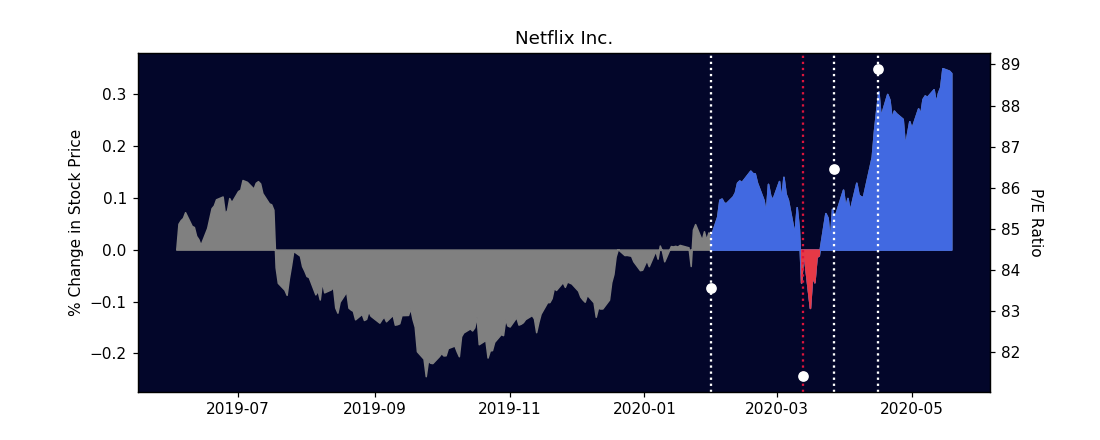

In [8]:
ticker_plot('nflx')

In [ ]:
# for tick in tick_list:
#     ticker_plot(tick)
#     time.sleep(16)

C:\Users\rona_\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


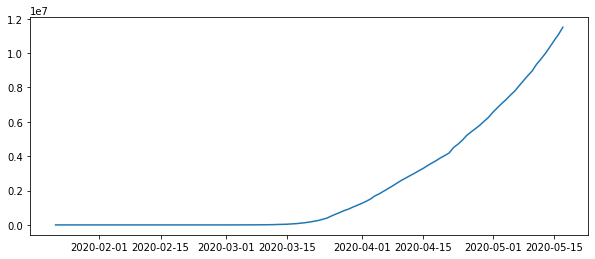

In [3]:
url = "https://covidtracking.com/api/v1/us/daily.json"
covid_df=pd.DataFrame(requests.get(url).json())
    
clean_covid_df = covid_df[['date', 'positive', 'total']]
clean_covid_df['date']=clean_covid_df['date'].apply(lambda x:datetime.strptime(str(x), '%Y%m%d'))
clean_covid_df

fig, ax=plt.subplots(figsize=(10,4))
ax.plot(clean_covid_df['date'],clean_covid_df["total"])

In [29]:
# Create a function to pull and visualize one company's stock data by passing in its ticker symbol

def ticker_plot2(ticker):
    ticker = ticker.lower()
    df, meta_df = ts.get_daily(symbol=str(ticker), outputsize = "full")

    # Data cleaning
    # Narrow the data to only get stock prices starting on June 1, 2019
    start_date = "2019-06-01"
    stock=df[df.index >= start_date]

    # Choose the closing price from our dataframe
    stock = stock[["4. close"]]
    # Get the stock price on the first day of our range
    start = stock["4. close"][-1]

    # Calculate the %change between the stock price on first day and stock price of each day after
    # Add %change data as a column called "change" in our dataframe
    stock["change"] = stock.apply(lambda x:(x-start)/start)

    # Get the full company name given the ticker symbol
    co = requests.get(f"https://www.alphavantage.co/query?function=SYMBOL_SEARCH&keywords={ticker}&apikey={api_key}").json()
    co_name = co["bestMatches"][0]["2. name"]

    # Create variable to store the start date of the pandemic
    stock_jan=stock[stock.index>='2020-01-31']
    
    # Visualization: hex color scheme = coolors.co/92374d-8c5383-4a5899-559cad-c1b2ab
    fig, ax=plt.subplots(figsize=(10,4))
    
    # Define the color for each area 
    ax.fill_between(stock.index,stock.change, color='gray')
    ax.fill_between(stock_jan.index, stock_jan.change, color='#4169e1')
    ax.fill_between(stock_jan.index,stock_jan.change,where=stock_jan.change<=0, color='#e63946')
    ax.set_facecolor('#03062a')
    
    # Add a vertical line to indicate important dates
    ax.axvline(pd.to_datetime('2020-01-31'), color='w', linestyle=':', label = 'Jan 31 - WHO declares COVID-19 as a pandemic')
    ax.axvline(pd.to_datetime('2020-03-13'), color='crimson', linestyle=':', label = 'Mar 13 - Trump declares a national emergency')
    ax.axvline(pd.to_datetime('2020-03-27'), color='w', linestyle=':', label = 'Mar 27 - Trump signs stimulus package')
    ax.axvline(pd.to_datetime('2020-04-16'), color='w', linestyle=':', label = 'Apr 16 - Trump issues guidlines to reopen')
    ax.set_title(co_name)
    ax.set_ylabel(f"% Change in Stock Price")
    
    # Overlay a scatter plot which represents the P/E ratio
#     pe_ratio = pe_df[ticker]
#     imp_dates = pe_df.index
#     ax2=ax.twinx()
#     ax2.scatter(imp_dates, pe_ratio, color='w')
#     ax2.set_ylabel("P/E Ratio",labelpad=15, rotation=270)
    
#     pe_ratio = pe_df[ticker]
#     imp_dates = pe_df.index
    ax2=ax.twinx()
    ax2.plot(clean_covid_df['date'],clean_covid_df["positive"], color = 'w')
    ax2.set_ylabel("COVID Cases",labelpad=15, rotation=270)
    ax2.set_ylim(1, 800)
    
    # Save our plot to a .png file
#     fig.savefig(f"../images2/{co_name}.png")

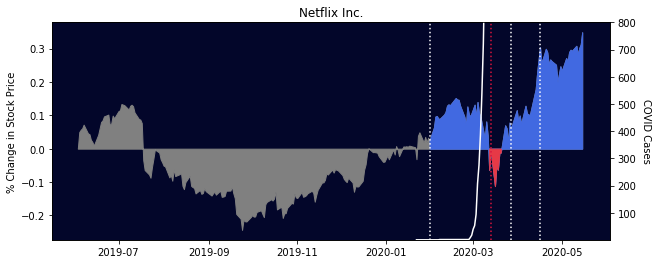

In [30]:
ticker_plot2('nflx')